In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from category_encoders.one_hot import OneHotEncoder


import eli5
from eli5.sklearn import PermutationImportance


#evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, plot_confusion_matrix, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
url = '../data/heart.csv'
data = pd.read_csv(url)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Attribute Information:

    * age - age in years 
    * sex - (1 = male; 0 = female) 
    * cp - chest pain type 
    * trestbps - resting blood pressure (in mm Hg on admission to the hospital) 
    * chol - serum cholestoral in mg/dl 
    * fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
    * restecg - resting electrocardiographic results 
    * thalach - maximum heart rate achieved 
    * exang - exercise induced angina (1 = yes; 0 = no) 
    * oldpeak - ST depression induced by exercise relative to rest 
    * slope - the slope of the peak exercise ST segment 
    * ca - number of major vessels (0-3) colored by flourosopy 
    * thal - 3 = normal; 6 = fixed defect; 7 = reversable defect 
    * target - have disease or not (1=yes, 0=no)

In [207]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


There is no null values, so no need to null handling step.

<AxesSubplot:xlabel='target', ylabel='count'>

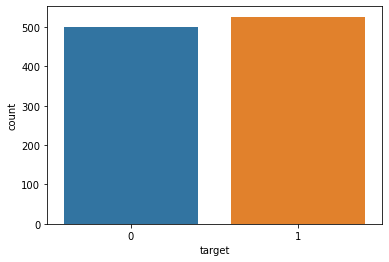

In [208]:
sns.countplot(data.target)

The Heart Disease Dataset has balanced data. 

Text(0.5, 1.0, 'Cardiac Patient Count vs Sex')

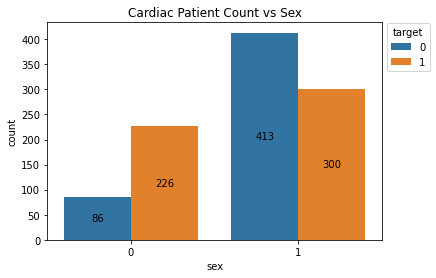

In [209]:
# 0 => Female
# 1 => Male

ax = sns.countplot(data=data, x='sex', hue='target', order=[0, 1])
sns.move_legend(ax, bbox_to_anchor=(1, 1.02), loc='upper left')

for c in ax.containers:
    
    # set the bar label
    ax.bar_label(c, label_type='center')
    
plt.title('Cardiac Patient Count vs Sex')

patientStatus = ['No Diseases', 'Has Diseases']
patientStatus = pd.Series(patientStatus)

femaleDiseaseRatio = (data[data['sex'] == 0]['target'].value_counts()/len(data[data['sex'] == 0])).to_frame()
maleDiseaseRatio = (data[data['sex'] == 1]['target'].value_counts()/len(data[data['sex'] == 1])).to_frame()

diseaseRatio = pd.concat([patientStatus, femaleDiseaseRatio, maleDiseaseRatio], axis=1)
diseaseRatio.set_index(0)

plot = diseaseRatio.plot.pie(subplots=True, figsize=(11, 6))

In [210]:
data.groupby(['sex','target']).sum()

age   cp  trestbps    chol  fbs  restecg  thalach  exang  \
sex target                                                               
0   0        5079   15     12598   23799   23       46    12242     50   
    1       12346  299     29117   57775   19      133    34817     24   
1   0       23149  226     54321  101596   59      182    57184    224   
    1       15221  426     38866   68980   52      182    48599     47   

            oldpeak  slope   ca  thal  
sex target                             
0   0         161.4     83  113   215  
    1         126.0    357   68   452  
1   0         637.1    499  465  1052  
    1         173.8    481  127   663

The bar chart illustrates female patients are more likely to have heart issues.

# EDA

In this section, correlation analysis and outlier detection will be reviewed, if it is required.

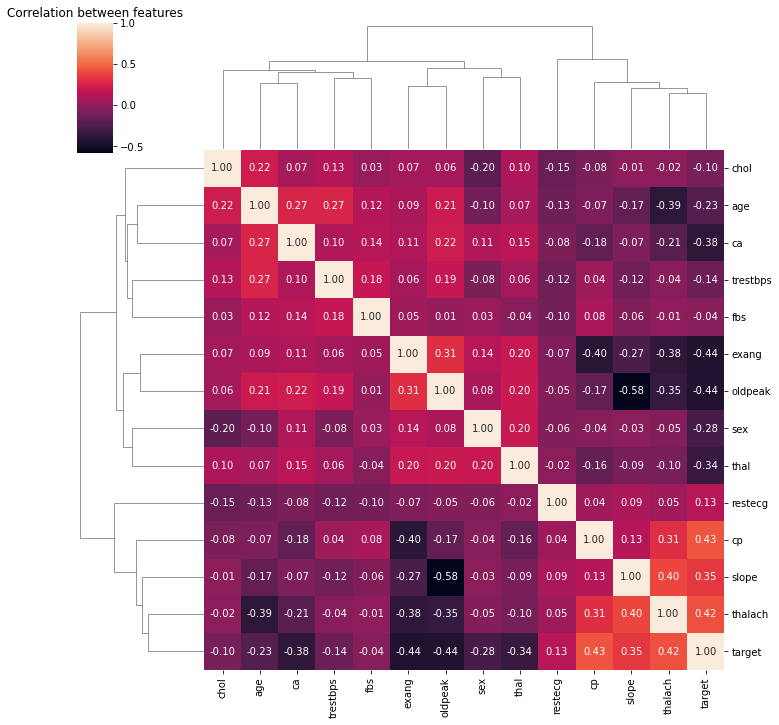

In [211]:
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title('Correlation between features')
plt.show()

According to instructions, I need to use only 5 features to predict heart disease. Correlation analysis could give me a chance to eliminate some correlated features; however there is no strong relation between features. 

Dataset contains both numerical and categorical variables. It can be separated before moving outlier detection.

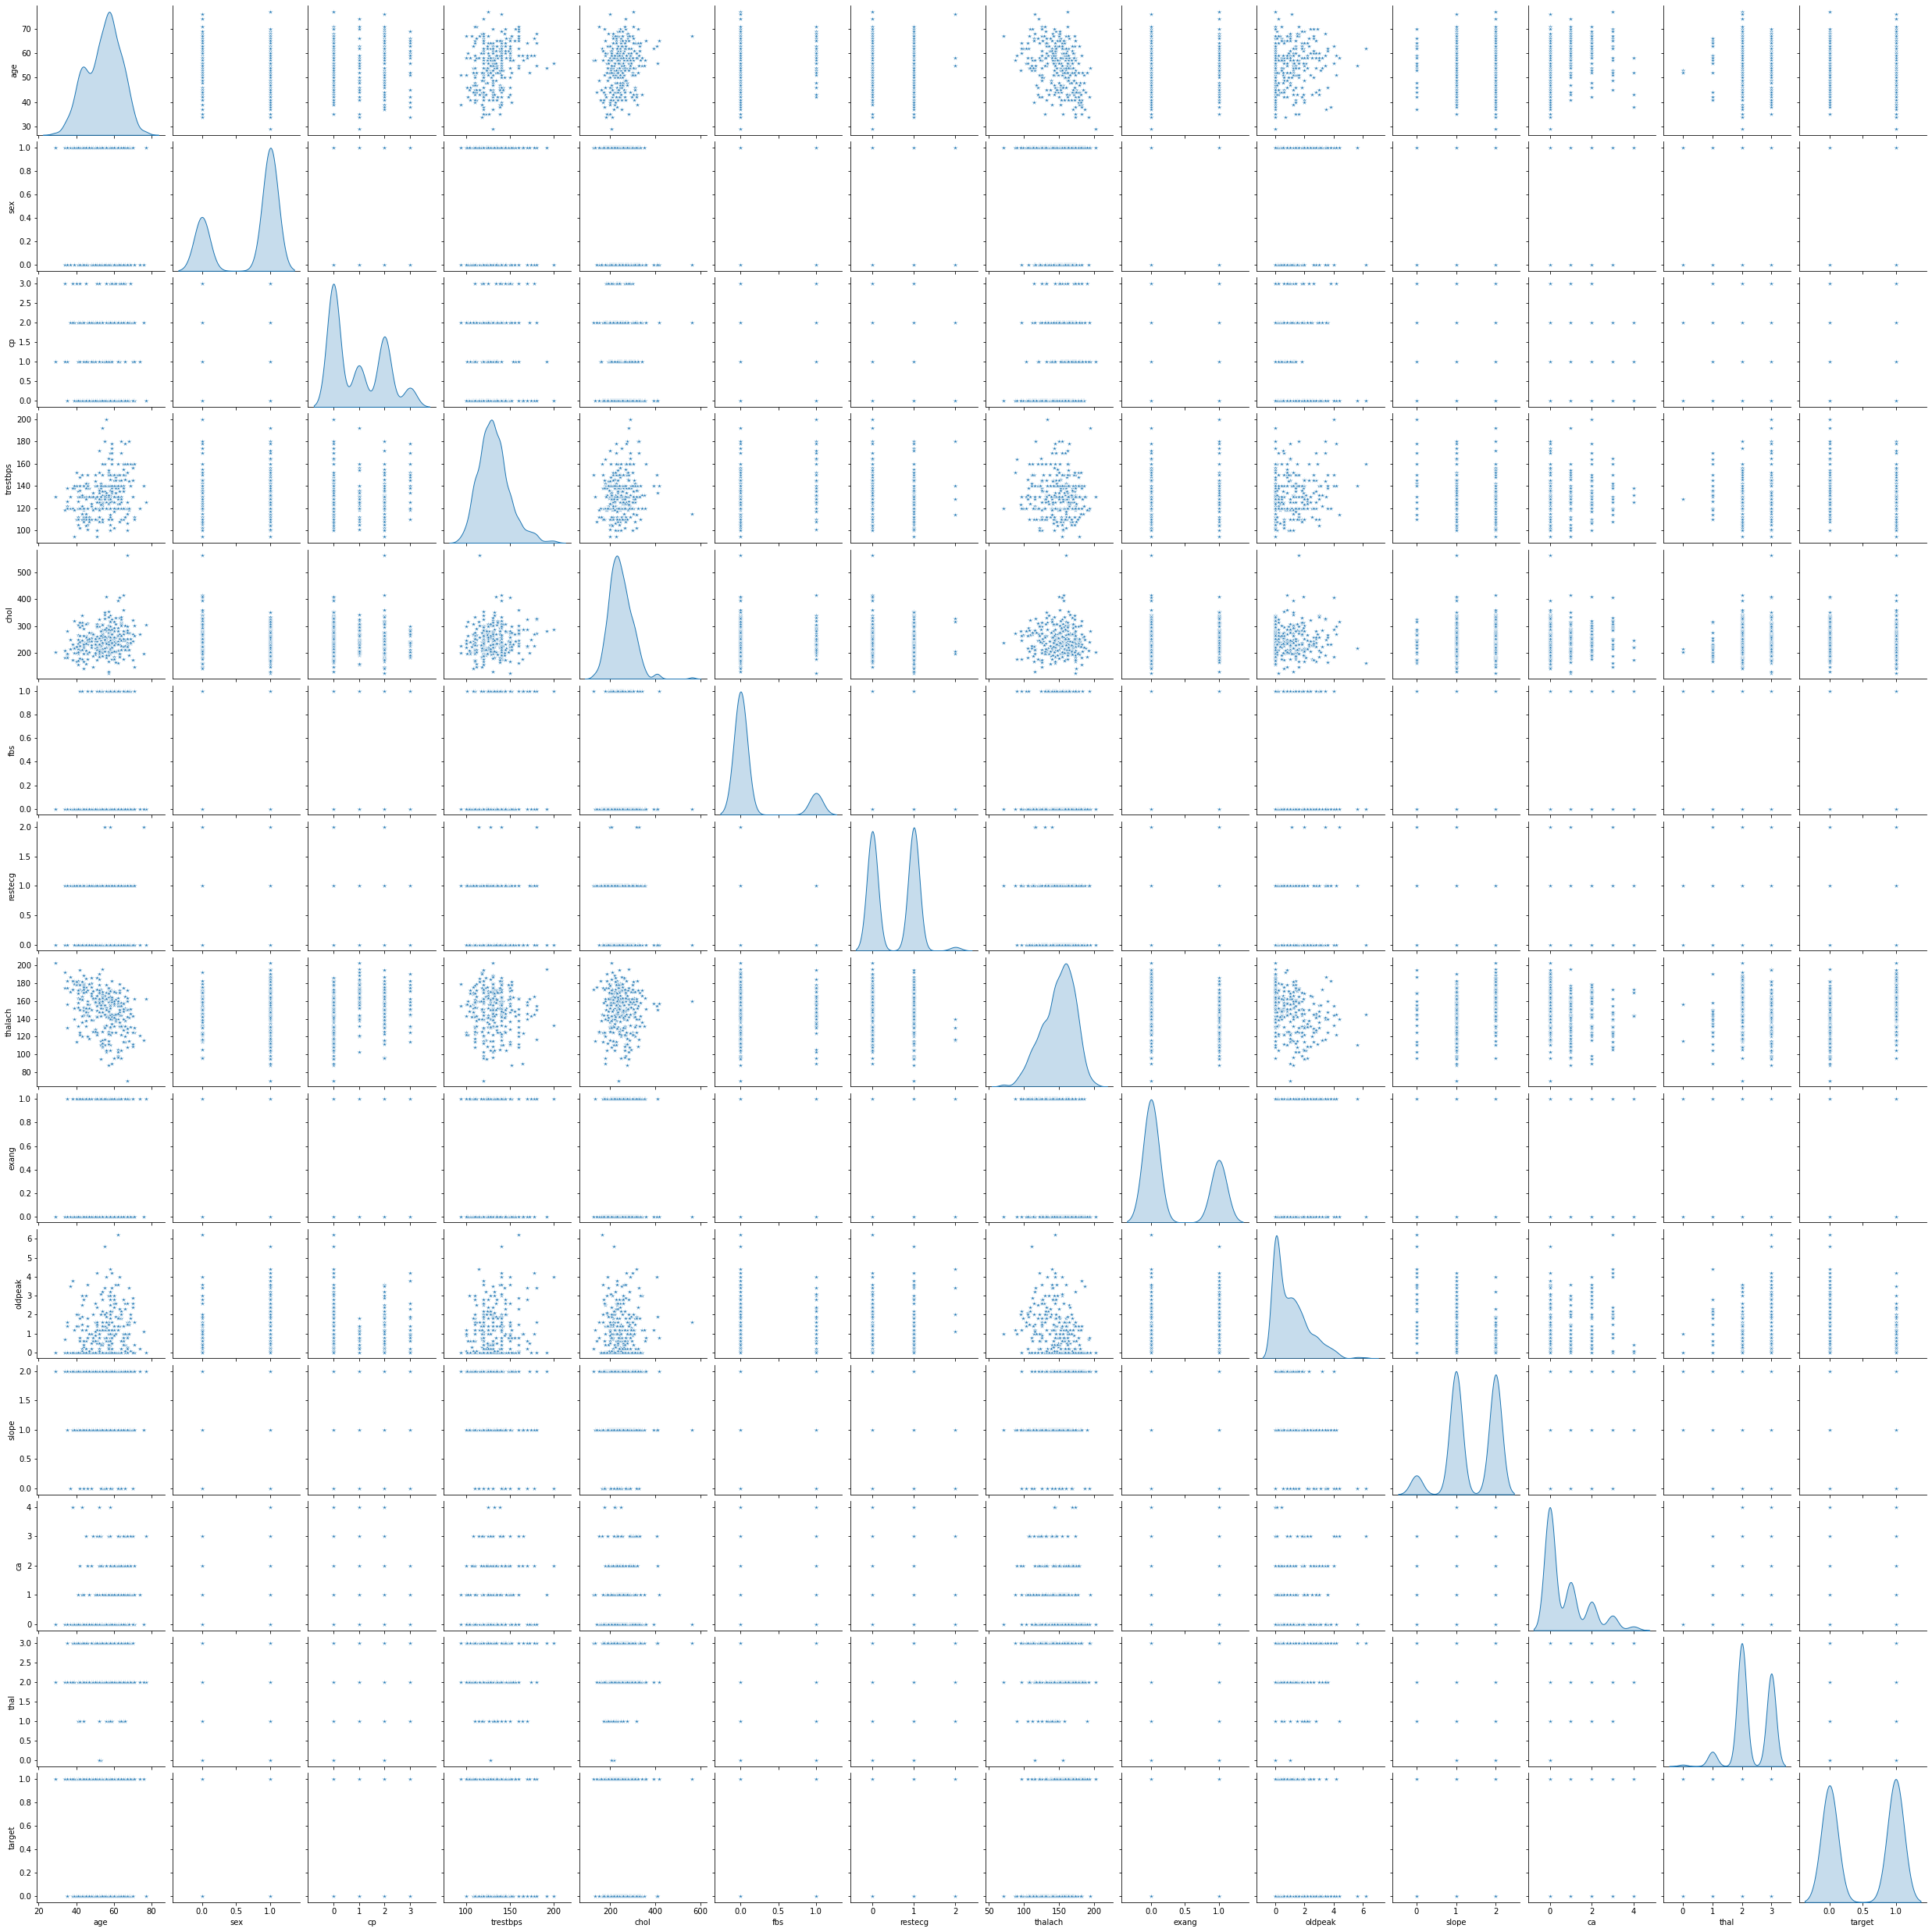

In [212]:
sns.pairplot(data, diag_kind="kde", markers="*")
plt.show()

It is a little bit tough to see the names. But let's zoom in the last row (target vs the rest), ["cp", "slope", "thal", "restecg", "ca"] might be categorical variables.
<br>Back to the dataset description, "restecg" and "ca" are numerical variables. Therefore "cp", "slope" and "thal" could be used as categorical.

In [213]:
data['cp'] = data['cp'].astype(str)
data['slope'] = data['slope'].astype(str)
data['thal'] = data['thal'].astype(str)

In [222]:
data = pd.get_dummies(data)
data.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,52,1,125,212,0,1,168,0,1.0,2,...,0,0,0,0,0,1,0,0,0,1
1,53,1,140,203,1,0,155,1,3.1,0,...,0,0,0,1,0,0,0,0,0,1
2,70,1,145,174,0,1,125,1,2.6,0,...,0,0,0,1,0,0,0,0,0,1
3,61,1,148,203,0,1,161,0,0.0,1,...,0,0,0,0,0,1,0,0,0,1
4,62,0,138,294,1,1,106,0,1.9,3,...,0,0,0,0,1,0,0,0,1,0


Outlier Detection

In [223]:
data.describe()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
count,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,...,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,0.754146,...,0.162927,0.277073,0.075122,0.072195,0.470244,0.457561,0.006829,0.062439,0.530732,0.400000
std,9.072290,0.460373,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,1.030798,...,0.369479,0.447771,0.263717,0.258937,0.499357,0.498439,0.082397,0.242069,0.499298,0.490137
min,29.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,61.000000,1.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,77.000000,1.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


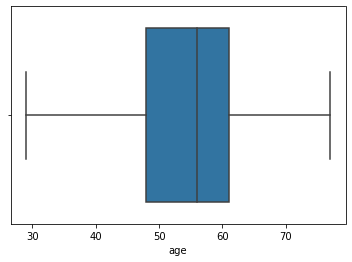

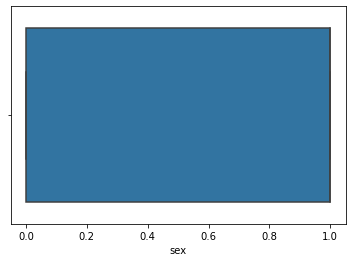

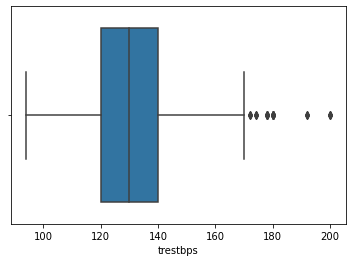

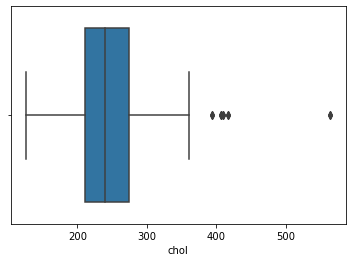

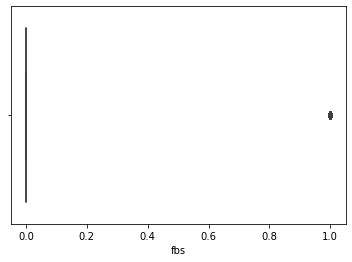

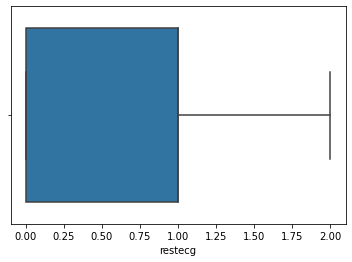

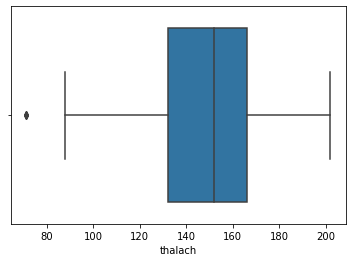

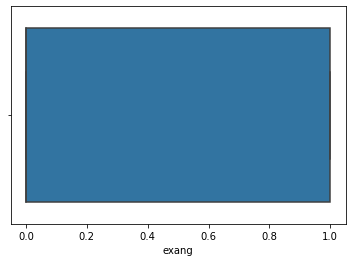

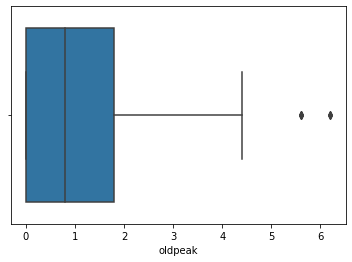

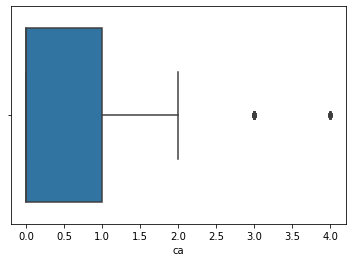

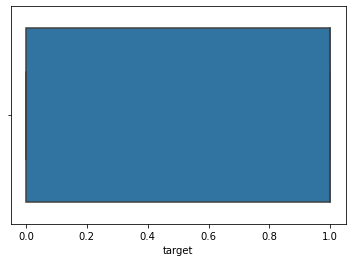

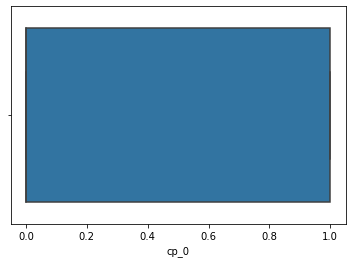

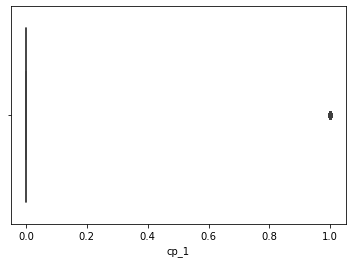

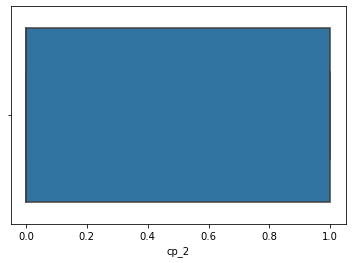

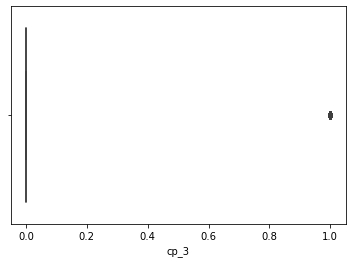

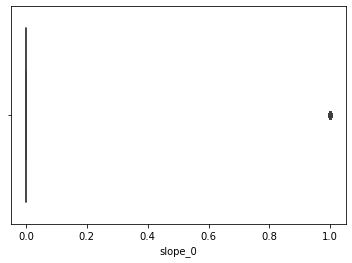

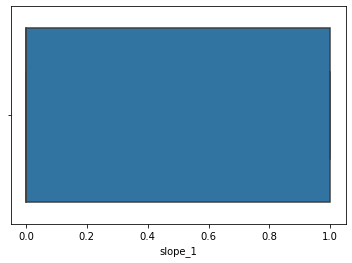

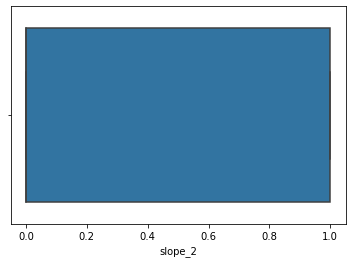

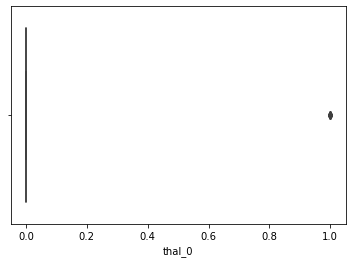

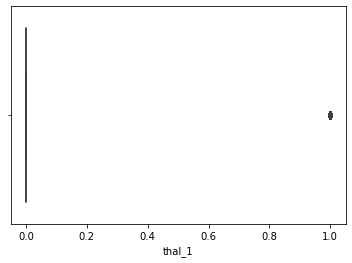

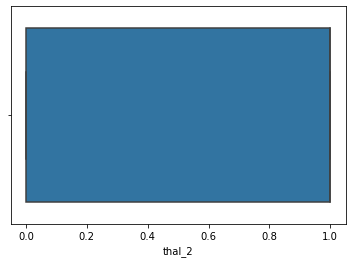

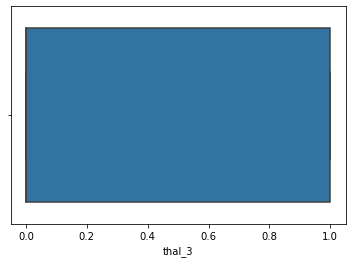

In [ ]:
for c in data.columns:
    plt.figure()
    sns.boxplot(x = c, data = data, orient = "v")

In [ ]:
def iqr_filter(column, thr):
    acceleration_desc = column.describe()
    q3_acc = acceleration_desc[6]
    q1_acc = acceleration_desc[4]
    iqr_acc = q3_acc - q1_acc

    top_limit_acc = q3_acc + thr*iqr_acc
    bottom_limit_acc = q1_acc - thr*iqr_acc

    filter_acc_bottom = bottom_limit_acc < column
    filter_acc_top = top_limit_acc > column
    filter_acc = filter_acc_bottom & filter_acc_top
    
    return filter_acc

I am not sure about outlier detection. high and low cholestoral could trigger heart disease. 

thr = 2

filter_result = iqr_filter(data_num['chol'], thr)

ege=data_num[filter_result]
len(ege)

# Train-Test Split

In [224]:
x = data.drop(columns="target")
y = data.target

In [225]:
scaler = StandardScaler()
x_std = scaler.fit_transform(x)
x_std

array([[-0.26843658,  0.66150409, -0.37763552, ..., -0.25806452,
        -1.06347409,  1.22474487],
       [-0.15815703,  0.66150409,  0.4791073 , ..., -0.25806452,
        -1.06347409,  1.22474487],
       [ 1.71659547,  0.66150409,  0.76468824, ..., -0.25806452,
        -1.06347409,  1.22474487],
       ...,
       [-0.81983438,  0.66150409, -1.23437834, ..., -0.25806452,
         0.9403144 , -0.81649658],
       [-0.4889957 , -1.51170646, -1.23437834, ..., -0.25806452,
         0.9403144 , -0.81649658],
       [-0.04787747,  0.66150409, -0.66321646, ..., -0.25806452,
        -1.06347409,  1.22474487]])

In [226]:
x_std= pd.DataFrame(x_std, 
                       index=x.index,
                       columns=x.columns)
x_std

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,-0.268437,0.661504,-0.377636,-0.659332,-0.418878,0.891255,0.821321,-0.712287,-0.060888,1.209221,...,-0.441179,-0.619085,-0.284998,-0.278950,-0.942158,1.088807,-0.082923,-0.258065,-1.063474,1.224745
1,-0.158157,0.661504,0.479107,-0.833861,2.387330,-1.004049,0.255968,1.403928,1.727137,-0.731971,...,-0.441179,-0.619085,-0.284998,3.584878,-0.942158,-0.918436,-0.082923,-0.258065,-1.063474,1.224745
2,1.716595,0.661504,0.764688,-1.396233,-0.418878,0.891255,-1.048692,1.403928,1.301417,-0.731971,...,-0.441179,-0.619085,-0.284998,3.584878,-0.942158,-0.918436,-0.082923,-0.258065,-1.063474,1.224745
3,0.724079,0.661504,0.936037,-0.833861,-0.418878,0.891255,0.516900,-0.712287,-0.912329,0.238625,...,-0.441179,-0.619085,-0.284998,-0.278950,-0.942158,1.088807,-0.082923,-0.258065,-1.063474,1.224745
4,0.834359,-1.511706,0.364875,0.930822,2.387330,0.891255,-1.874977,-0.712287,0.705408,2.179817,...,-0.441179,-0.619085,-0.284998,-0.278950,1.061393,-0.918436,-0.082923,-0.258065,0.940314,-0.816497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.503520,0.661504,0.479107,-0.484803,-0.418878,0.891255,0.647366,1.403928,-0.912329,-0.731971,...,2.266655,-0.619085,-0.284998,-0.278950,-0.942158,1.088807,-0.082923,-0.258065,0.940314,-0.816497
1021,0.613800,0.661504,-0.377636,0.232705,-0.418878,-1.004049,-0.352873,1.403928,1.471705,0.238625,...,-0.441179,-0.619085,-0.284998,-0.278950,1.061393,-0.918436,-0.082923,-0.258065,-1.063474,1.224745
1022,-0.819834,0.661504,-1.234378,0.562371,-0.418878,-1.004049,-1.353113,1.403928,-0.060888,0.238625,...,-0.441179,-0.619085,-0.284998,-0.278950,1.061393,-0.918436,-0.082923,-0.258065,0.940314,-0.816497
1023,-0.488996,-1.511706,-1.234378,0.155137,-0.418878,-1.004049,0.429923,-0.712287,-0.912329,-0.731971,...,-0.441179,-0.619085,-0.284998,-0.278950,-0.942158,1.088807,-0.082923,-0.258065,0.940314,-0.816497


In [227]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size = .33, random_state=35, stratify=y)

In [228]:
random_state = 35

classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             KNeighborsClassifier(),
             XGBClassifier(random_state = random_state)]

dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000]}

rf_param_grid = {"max_features": [1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}

xgb_param_grid = {"learning_rate": np.linspace(0.01,0.2,5, dtype = float).tolist(),
                 "max_depth": [1,3,10],
                 "gamma": [0, 0.25, 1],
                 "reg_lambda": [0, 1, 10],
                 "scale_pos_weight": [1, 3, 5],
                 "subsample": [0.8],
                 "colsample_bytree": [0.5]}

classifier_param = [dt_param_grid,
                   svc_param_grid,
                   rf_param_grid,
                   knn_param_grid,
                   xgb_param_grid]

In [229]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = 5, scoring = "accuracy")
    clf.fit(x_train,y_train)
    cv_result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)
    y_pred_clf = clf.predict(x_test)
    print(f"{classifier[i]} has best score is: {cv_result[i]}\n")
    print(f"The f1score is {f1_score(y_test, y_pred_clf)}")

DecisionTreeClassifier(random_state=35) has best score is: 0.908134983603089

The f1score is 0.9309309309309309
SVC(random_state=35) has best score is: 0.9620966888818365

The f1score is 0.9794721407624634
RandomForestClassifier(random_state=35) has best score is: 0.9664868295779119

The f1score is 0.9794721407624634
KNeighborsClassifier() has best score is: 0.9664868295779119

The f1score is 0.9794721407624634
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, 

In [ ]:
clf.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.15250000000000002,
 'max_depth': 10,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8}

Text(0.5, 1.0, 'Cross Validation Scores')

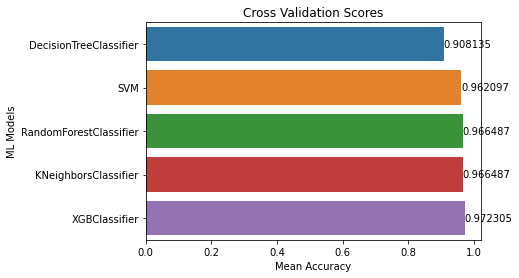

In [ ]:
cv_results = pd.DataFrame({"Cross Validation Means":cv_result, "ML Models":["DecisionTreeClassifier", "SVM","RandomForestClassifier",
             "KNeighborsClassifier","XGBClassifier"]})

g = sns.barplot("Cross Validation Means", "ML Models", data = cv_results)
g.bar_label(g.containers[0])
g.set_xlabel("Mean Accuracy")
g.set_title("Cross Validation Scores")

As a result of model metrics, I prefer to move with XGBClassifier. Even KNeighbors has higher f1score, XGB gives better numbers considering cv score and accuracy.

<AxesSubplot:>

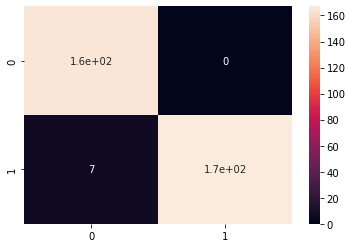

In [ ]:
xgb = XGBClassifier(colsample_bytree=0.5,
                     gamma=0,
                     learning_rate=0.15250000000000002,
                     max_depth=10,
                     reg_lambda=1,
                     scale_pos_weight=1,
                     subsample=0.8,
                     random_state = 35)

xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

xgb_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(xgb_cm, annot=True)

Feature: 0, Score: 0.02419
Feature: 1, Score: 0.05044
Feature: 2, Score: 0.02026
Feature: 3, Score: 0.02435
Feature: 4, Score: 0.03379
Feature: 5, Score: 0.01640
Feature: 6, Score: 0.03163
Feature: 7, Score: 0.07262
Feature: 8, Score: 0.03610
Feature: 9, Score: 0.09236
Feature: 10, Score: 0.16130
Feature: 11, Score: 0.00943
Feature: 12, Score: 0.03403
Feature: 13, Score: 0.03128
Feature: 14, Score: 0.05947
Feature: 15, Score: 0.01522
Feature: 16, Score: 0.04594
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.01721
Feature: 19, Score: 0.05902
Feature: 20, Score: 0.16496


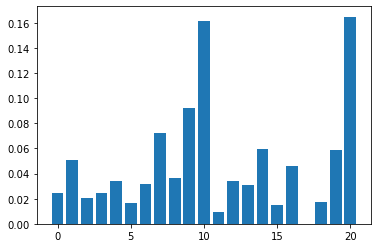

In [ ]:
importance = xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
perm = PermutationImportance(xgb, random_state=35).fit(x_train, y_train)
eli5.show_weights(perm, feature_names = x_train.columns.tolist())

Weight,Feature
0.0822 ± 0.0060,ca
0.0423 ± 0.0037,cp_0
0.0259 ± 0.0029,age
0.0172 ± 0.0043,chol
0.0166 ± 0.0070,thalach
0.0149 ± 0.0050,oldpeak
0.0117 ± 0.0032,sex
0.0076 ± 0.0047,thal_2
0.0070 ± 0.0039,exang
0.0061 ± 0.0022,trestbps


According to table above, the 5 highest significant features are "ca", "cp", "age", "chol" and "thalach".